<a href="https://colab.research.google.com/github/pchatfield/coin-analyzer/blob/main/Coin_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin Analysis Project

Implement deep learning techniques on coin image data

test code source: https://www.kaggle.com/wanderdust/coin-prediction-using-keras-cnn

## Data Issues

- Some images of both inverse and obverse
- Images are grouped on type of coin
- Image category information formatted in JSON


In [ ]:
# imports

import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, image
from keras.utils import np_utils
import json
from PIL import Image
import numpy as np

In [ ]:
# import data from drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/My Drive/Data Science Projects/coins/data"

In [ ]:
data_train_path =  data_dir + '/train'
data_valid_path = data_dir + '/validation'
data_test_path =  data_dir + '/test'

In [ ]:
with open('/content/drive/My Drive/Data Science Projects/cat_to_name.json', 'r') as json_file:
    cat_2_name = json.load(json_file)

print(cat_2_name['200'])

1 Kurus,Turkish Lira,turkey


** Possibly want to relabel/reorganize category information for different purposes **

In [ ]:
batch_size=60

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_std_normalization=True, # Normalize images
    samplewise_std_normalization=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:


train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator = datagen_valid.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')



Found 6430 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 845 images belonging to 211 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

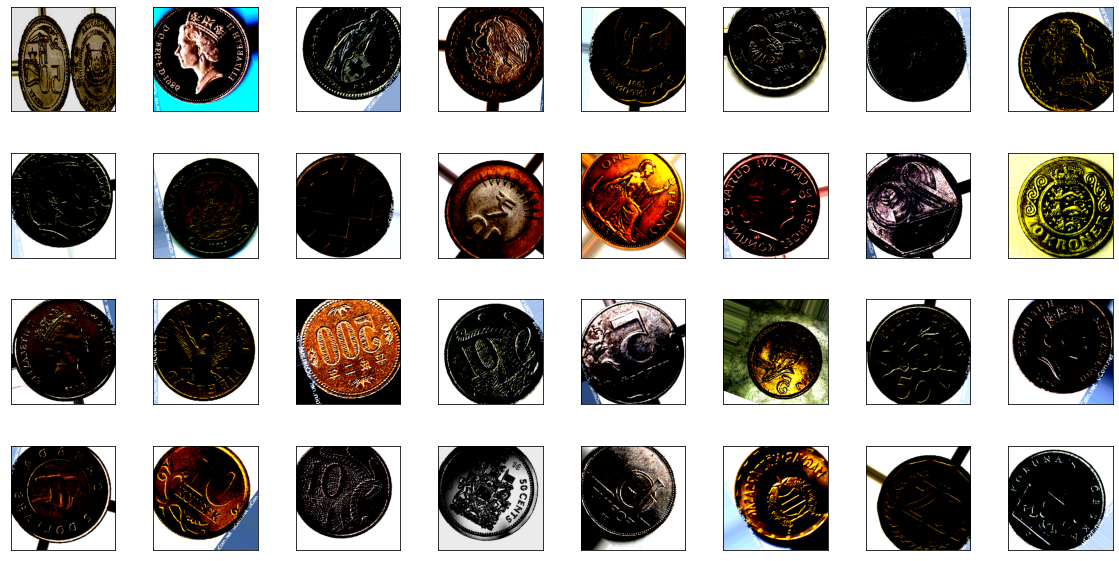

In [ ]:

# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])

In [ ]:
int_to_dir = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
# from keras.applications import ResNet50
from keras.models import Model



base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet"
)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
x = Dropout(0.95)(x)
# and a logistic layer
predictions = Dense(211, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# from keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(train_generator.filenames)


# When to save the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# Reduce learning rate when loss doesn't improve after n epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

# Train the model
history = model.fit_generator(train_generator,
                    steps_per_epoch=num_train//batch_size,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
107/107 [==============================] - 1848s 17s/step - loss: 7.0726 - accuracy: 0.0058 - val_loss: 5.5093 - val_accuracy: 0.0048

Epoch 00001: val_loss improved from inf to 5.50929, saving model to model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
107/107 [==============================] - 169s 2s/step - loss: 5.4566 - accuracy: 0.0072 - val_loss: 5.3692 - val_accuracy: 0.0048

Epoch 00002: val_loss improved from 5.50929 to 5.36921, saving model to model.weights.best.hdf5
Epoch 3/20
107/107 [==============================] - 168s 2s/step - loss: 5.3702 - accuracy: 0.0104 - val_loss: 5.3512 - val_accuracy: 0.0036

Epoch 00003: val_loss improved from 5.36921 to 5.35121, saving model to model.weights.best.hdf5
Epoch 4/20
107/107 [==============================] - 169s 2s/step - loss: 5.2884 - accuracy: 0.0193 - val_loss: 5.3290 - val_accuracy: 0.0119

Epoch 00004: val_loss improved from 5.35121 to 5.32899, saving model to model.weights.best.hdf5
Epoch 5/20
107/107 [==============================] - 171s 2s/step - loss: 5.1531 - accuracy: 0.0394 - val_loss: 5.2116 - val_accuracy: 0.0512

Epoch 00005: val_loss improved from 5.32899 to 5.21158, saving model to model.weights.best.hdf5
Epoch 6/20
107/107 [====================

In [ ]:
model.load_weights('../input/weightskerascoincnn/model.weights.best.hdf5')

In [ ]:
score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


6430/6430 [==============================] - 196s 30ms/step - loss: 1.0801 - accuracy: 0.7716

 Test accuracy: 0.7715976238250732


In [ ]:
def get_prediction(img, real_label):
    img = image.img_to_array(img)/255
    
    #normalise image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = (img - mean)/std
    
    img_expand = np.expand_dims(img, axis=0)

    prediction = model.predict(img_expand)
    prediction_int = np.argmax(prediction)

    dir_int = int_to_dir[prediction_int]
    label_name = cat_2_name[str(dir_int)]
    
    print("Predicted: {}\nReal:      {}".format(label_name, cat_2_name[str(real_label)]))
    print()


for i in range(10):
    random_index = np.random.randint(0, len(test_generator.filenames))
    
    img = test_generator.filenames[random_index]
    img = image.load_img("../input/coin-images/coins/data/test/"+img, target_size=(224,224))
    real_label = test_generator.filenames[random_index].split("/")[0]

    get_prediction(img, real_label)

FileNotFoundError: ignored